### Investigation of Top Mass Reweighting

This notebook investigates DCTR reweighting performance on top mass daset

* We use only the hadronic mass as input data and top mass as parameter
* We use 5 layers DNN which is comparable to the Gaussian reweighting version
* The model is tested on reweighting from both particle and detector datasets

### Imports

In [87]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [88]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

### Load the truth data for top mass 172.5 and split 80% for training and 20% for testing

In [89]:
data_dir = 'DCTRFitting/'

In [90]:
default_had_mass_all = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,1]
default_had_mass = default_had_mass_all[:int(len(default_had_mass_all)*0.8)]
test_had_mass = default_had_mass_all[int(len(default_had_mass_all)*0.8):]

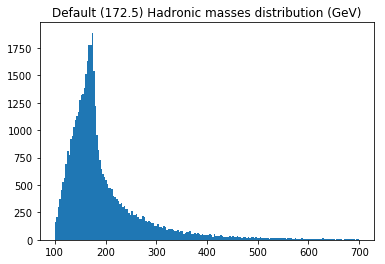

In [116]:
plt.hist(default_had_mass, bins = np.linspace(100,700,200))
plt.title("Default (172.5) Hadronic masses distribution (GeV)")
plt.show()

In [92]:
truth_had_mass = np.load(data_dir+ 'part_175_0_6j_obs.npy')[:,1][:len(default_had_mass)]

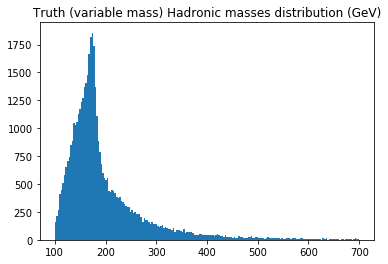

In [117]:
plt.hist(truth_had_mass, bins = np.linspace(100,700,200))
plt.title("Truth (variable mass) Hadronic masses distribution (GeV)")
plt.show()

### Plot the distribution of top mass (should be uniformly around 170-180)

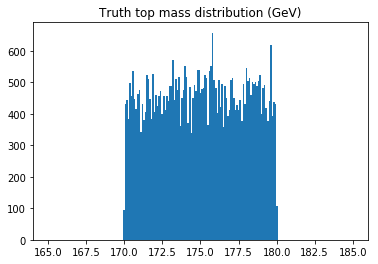

In [94]:
mu_values = np.load(data_dir+ 'part_varmass_6j.npy')[:,0,-1][:len(default_had_mass)]
plt.hist(mu_values, bins = np.linspace(165,185,200))
plt.title("Truth top mass distribution (GeV)")
plt.show()

### Prepare sample for DCTR reweighting

In [95]:
X0 = default_had_mass
Y0 = to_categorical(np.zeros(len(X0)), num_classes=2)

In [96]:
X1 = truth_had_mass
Y1 = to_categorical(np.ones(len(X1)), num_classes=2)

In [99]:
X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

### Define a 5 layer DNN for reweighting

In [100]:
inputs = Input((1,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
hidden_layer_5 = Dense(50, activation='relu')(hidden_layer_4)

outputs = Dense(2, activation='softmax')(hidden_layer_5)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

In [101]:
dctr_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                100       
_________________________________________________________________
dense_20 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 102       
Total para

In [102]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=20, 
          batch_size = 100,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])


Train on 73868 samples, validate on 18468 samples
Epoch 1/20
73868/73868 [==============================] - 5s 72us/step - loss: 0.7218 - val_loss: 0.6962
Epoch 2/20
73868/73868 [==============================] - 5s 64us/step - loss: 0.6986 - val_loss: 0.6944
Epoch 3/20
73868/73868 [==============================] - 5s 64us/step - loss: 0.6959 - val_loss: 0.6945
Epoch 4/20
73868/73868 [==============================] - 5s 64us/step - loss: 0.6938 - val_loss: 0.6947
Epoch 5/20
73868/73868 [==============================] - 5s 64us/step - loss: 0.6937 - val_loss: 0.6931
Epoch 6/20
73868/73868 [==============================] - 5s 64us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/20
73868/73868 [==============================] - 5s 65us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/20
73868/73868 [==============================] - 5s 64us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/20
73868/73868 [==============================] - 5s 64us/step - loss: 0.6932 - val_loss: 0.6931
Epoch

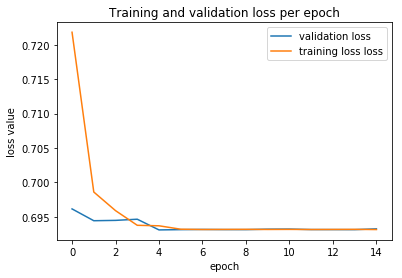

In [103]:
plt.title("Training and validation loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.plot(dctr_model.history.history['val_loss'], label = "validation loss")
plt.plot(dctr_model.history.history['loss'], label = "training loss loss")
plt.legend()
plt.show()

## Reweighting from data of mass 175 to 172.5 

### Reweighting of particle dataset

In [104]:
X0_test = test_had_mass
X1_test = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,1][:len(X0_test)]

In [105]:
preds = dctr_model.predict(X0_test)
weights = preds[:,1]/preds[:,0]

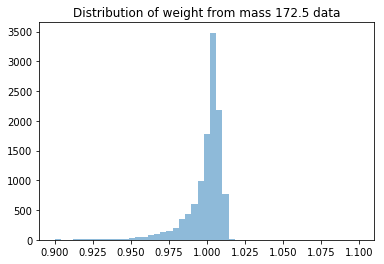

In [106]:
bins = np.linspace(0.9,1.1,50)
plt.hist(weights_0, bins = bins, alpha = 0.5)[0]
plt.title("Distribution of weight from mass 172.5 data")
plt.show()

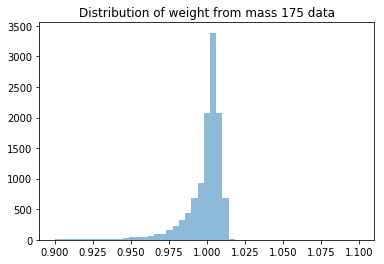

In [107]:
bins = np.linspace(0.9,1.1,50)
plt.hist(weights_1, bins = bins, alpha = 0.5)[0]
plt.title("Distribution of weight from mass 175 data")
plt.show()

In [108]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

1.0146579
1.3313698
1.0152061
1.2609599


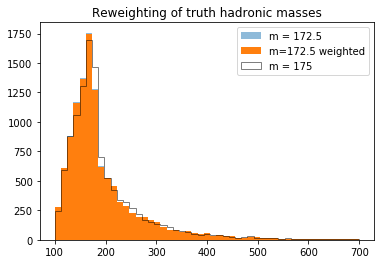

In [109]:
bins = np.linspace(100,700,50)
plt.title("Reweighting of truth hadronic masses")

target_data_hist = plt.hist(X0_test, bins = bins, alpha = 0.5, label = 'm = 172.5')[0]
reweight_data_hist = plt.hist(X0_test, bins = bins, label = 'm=172.5 weighted', weights=weights)[0]
default_data_hist = plt.hist(X1_test, bins = bins, alpha = 0.5, label = 'm = 175',histtype='step', color='k')[0]
plt.legend()
plt.show()

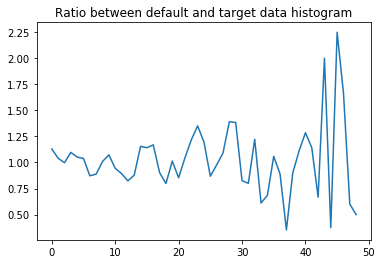

In [110]:
plt.title("Ratio between default and target data histogram")
plt.plot(target_data_hist/default_data_hist)
plt.show()

### Reweighting of detector datasets

In [111]:
X0_test = np.load(data_dir + 'det_172_5_6j_obs.npy')[:,1][int(len(default_had_mass_all)*0.8):]
X1_test = np.load(data_dir + 'det_175_0_6j_obs.npy')[:,1][:len(X0_test)]

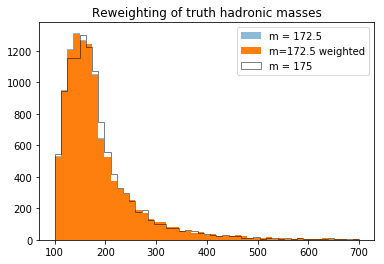

In [115]:
bins = np.linspace(100,700,50)
plt.title("Reweighting of truth hadronic masses")

target_data_hist = plt.hist(X0_test, bins = bins, alpha = 0.5, label = 'm = 172.5')[0]
reweight_data_hist = plt.hist(X0_test, bins = bins, label = 'm=172.5 weighted', weights=weights)[0]
default_data_hist = plt.hist(X1_test, bins = bins, alpha = 0.5, label = 'm = 175',histtype='step', color='k')[0]
plt.legend()
plt.show()

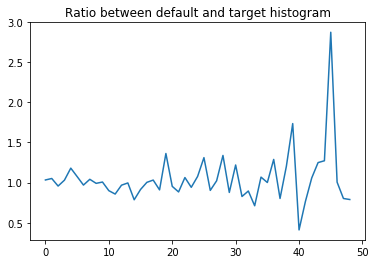

In [114]:
plt.title("Ratio between default and target histogram")
plt.plot(default_data_hist/reweight_data_hist)
plt.show()